In [1]:
# Aras: This is the bash/Shell commandline reminder/testing terminal/console.
% cd 
% ls
% cd deep-learning/first-neural-network/

/Users/arasdar
Applications/     Library/          Public/           notes
Desktop/          Movies/           anaconda3/
Documents/        Music/            deep-learning/
Downloads/        Pictures/         google-cloud-sdk/
/Users/arasdar/deep-learning/first-neural-network


# My NN with two hidden layer

In this project, I will build my NN with two hidden layers to predict daily bike rental ridership.

In [2]:
# These are commandline commnads or console/terminal/bash/shell commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Required libs/packages: Anaconda (env), Jupyter, Notebook, Python, numpy, matplotlib, and pandas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. 
Variables on different scales are difficult for learning the network parameters. 
Below, we load and prepare the data.

In [3]:
# Aras: the dataset is already provided though!
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. 
The number of riders is split between casual and registered, summed up in the `cnt` column. 
You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. 
You can see the hourly rentals here. 
This data is pretty complicated! 
The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. 
Looking at the data above, we also have information about temperature, humidity, and windspeed, all of which are likely affecting the number of riders. 
You'll be trying to capture all this with your model.

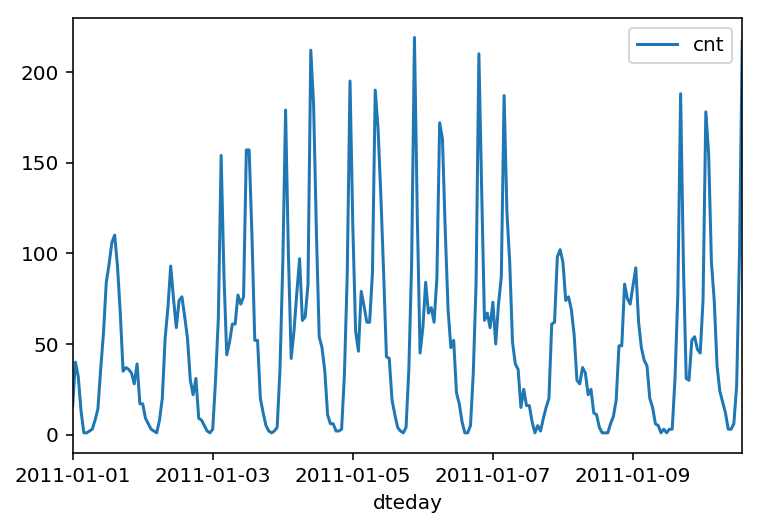

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables such as season, weather, and month. 
To include these in our NN, we'll need to make binary dummy variables. 
This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make NN training/learning easier, we'll standardize each of the continuous variables/dimensions/features/input units. 
That is why we shift and scale the variables such that they have zero mean/loc and a standard deviation/scale/sigma of 1.0 (equal radius).
The scaling factors are saved so that we can go backwards when we use the NN for predictions/testing.

#### Aras: I wonder this variable/dimension/feature scaling to max/min has a biological basis though? 

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, validation, and testing sets.

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. 
We'll use this test set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets: one for training and one for validating while the network is being trained. 
Since this is time-series data, we'll train on historical data/time-series/sequential data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below I will build my network. 
You'll implement the forward pass in each epoch through the network. 
You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes/epochs, and the number of training props which is equal to the random batch size from the dataset.

The network has two hidden layers and two visible layers: input and output layer. 
The hidden layers will use an activation function such as LU and Sigmoid currently. 

The output layer has only one node at the moment and is used for the regression, the output of the node is the same as the input of the node. 
That is, the activation function is $f(x)=x$ (LU or Linear Unit). 
A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. 
We work through each layer of our network calculating the outputs for each neuron/units. 
All of the outputs from one layer become inputs to the neurons on the next layer. 
This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. 
We use the weights to also propagate error backwards from the output back into the network to update our weights. 
This is called *backpropagation* (BP).

> **Hint:** We'll need the derivative of the output activation function ($f(x)$) for the backpropagation implementation, related to the calculus in mathematics.

Below are the steps:
1. Implement the activation function for the output layers and hidden layers. 
Set `self.activation_function` in `__init__`.
2. Implement the forward pass in the `train` method for each epoch.
3. Implement the backpropagation algorithm in the `train` method in each prop, including calculating the output error.
4. Implement the forward pass in the `run` method for each epoch as well.  

In [20]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, output_nodes, learning_rate, hidden1_nodes, hidden2_nodes):
        
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.output_nodes = output_nodes
        self.hidden1_nodes = hidden1_nodes
        self.hidden2_nodes = hidden2_nodes
        
        # Initialize the weights for the hidden 2: inputs and outputs - let's start with one input and one output -- simplese version
        #self.weights_input_to_hidden2 = np.random.normal(loc=0.0, scale=1.0, size=) #mat_nxh2
        self.weights_hidden1_to_hidden2 = np.random.normal(loc=0.0, scale=1.0, 
                                                           size=(self.hidden1_nodes, self.hidden2_nodes)) #mat_h1xh2
        #self.weights_hidden2_to_hidden1 = np.random.normal(loc, scale, size) #mat_h2_h1 # h2-h1 or h1-h2
        self.weights_hidden2_to_output = np.random.normal(loc=0.0, scale=1.0, 
                                                          size=(self.hidden2_nodes, self.output_nodes)) #mat_h2xm
        self.biases_hidden2_layer = np.random.normal(loc=0.0, scale=1.0, size=(1, self.hidden2_nodes)) #mat_1xh2

        # Initialize weights for inputs to outputs
        # numpy.random.normal(loc=0.0, scale=1.0, size=None)¶
        self.weights_input_to_output = np.random.normal(loc=0.0, scale=1.0,
                                                        size=(self.input_nodes, self.output_nodes)) # mat_nxm
        self.biases_output_layer = np.random.normal(loc=0.0, scale=1.0, size=(1, self.output_nodes)) # mat_1xm 
        
        # Initialize weights for input to hidden1 and hidden1 to output
        self.weights_input_to_hidden1 = np.random.normal(loc=0.0, scale=1.0,
                                                          size=(self.input_nodes, self.hidden1_nodes)) # mat_nxh1
        self.biases_hidden1_layer = np.random.normal(loc=0.0, scale=1.0, size=(1, self.hidden1_nodes)) #mat_1xh1
        self.weights_hidden1_to_output = np.random.normal(loc=0.0, scale=1.0, 
                                                          size=(self.hidden1_nodes, self.output_nodes)) #mat_h1xm
        
        
        # Aras: This should be adaptive eventualy, i.e. adaptive learning rate inspired by my gym's thought on the pace of working out!
        self.learning_rate = learning_rate

        # Aras: Activation function is also a question. 
        # This should NOT be linear (i.e. non-linearity/non-linear function) ~ almost linear/ not completly linear though
        # Aras: Some functions kills the gradient such as Tanh and Sigmoid. 
        # It should also not be computationally expensive functions such as Tanh, Sigmoid, and ELU.
        # Aras: unexpensive, max gradient~1, and non-linear but ~linear such as ReLU and PReLU.
        def sigmoid(x): # NOT ideal
            return 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation here
    
        # Aras: NOT ideal though.
        # There has to be some non-linearity the same neuron cell body, ~ linear but non-linear like ReLU/ PReLU.
        def LU(x):
            return x # This is actually what is suggested in this part which is perfectly linear. This is NOT the case though.
        
        # Aras: This should be equal in the entire network. 
        # It should be cheap, non-linear/~linear with the max derivative~=1
        # Aras: Can we learn this as well?
        self.activation_function = sigmoid #LU # Linear Unit
        self.activation_derivative = 1
   
    # Stochastic Gradient Descent (SGD)
    def train(self, inputs_list, targets_list):
        
        ## TODO
        #         # Fwd/Bwd prop/pass
        #         self.run(self, inputs_list)
        #         self.bp(self, inputs_list, targets_list, final_outputs)
        
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2) #mat_1xn 
        targets = np.array(targets_list, ndmin=2) #mat_1xm

        #### Implement the forward pass here ####
        ### Forward pass ###
        ## TODO: Output layer - Replace these values with your calculations.
        # 1st path directly from input to the output layer
        output_layer_in = np.dot(inputs, self.weights_input_to_output) # mat_1xm=np.dot(mat_1xn, mat_nxm)

        # 2nd Path for forward prop/pass: path with one hidden layer: h1
        hidden1_layer_in = np.dot(inputs, self.weights_input_to_hidden1) #mat_1xh1=np.dot(mat_1xn, mat_nxh1)
        hidden1_layer_in += self.biases_hidden1_layer #mat_1xh1
        hidden1_layer_out = self.activation_function(x=hidden1_layer_in) #mat_1xh1
        output_layer_input_from_hidden1 = np.dot(hidden1_layer_out, self.weights_hidden1_to_output) #mat_1xm=np.dot(mat_1xh1, mat_h1xm)    
        output_layer_in += output_layer_input_from_hidden1 #mat_1xm

        # 3rd path through hidden layer 2
        hidden2_layer_in = np.dot(hidden1_layer_out, self.weights_hidden1_to_hidden2) #mat_1xh2=np.dot(mat_1xh1, mat_h1xh2)
        hidden2_layer_in += self.biases_hidden2_layer #mat_1xh2
        hidden2_layer_out = self.activation_function(x=hidden2_layer_in) #mat_1xh2
        output_layer_input_from_hidden2 = np.dot(hidden2_layer_out, self.weights_hidden2_to_output) #mat_1xm=np.dot(mat_1xh2, mat_h2xm)
        output_layer_in += output_layer_input_from_hidden2
        
        # output biases are also added to the total output layer inputs
        output_layer_in += self.biases_output_layer # mat_1xm
        final_outputs = self.activation_function(x=output_layer_in) #mat_1xm # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        ## TODO: Output error - Replace this value with your calculations. 
        # targets==y_ref, final_outputs==y_res
        output_errors = (targets - final_outputs) # mat_1xm 
        # output_errors is the difference between desired target and actual output.
        output_layer_delta = output_errors * self.activation_derivative # mat_1xm 
        # activation functon for output layer is f(x)=x and derivative is 1 (slope).

        # TODO: Update the output biases - Replace these values with your calculations.
        biases_output_layer_grad = output_layer_delta # mat_1xm

        # Update the weights using weights gradients/ delta_w for the 1st path without any hidden layers - direct input to output path
        weights_input_to_output_grad = np.dot(output_layer_delta.T, inputs).T # mat_nxm=np.dot(mat_1xm.T, mat_1xn).T

        # Update the weights in the 2nd path with hidden layer, i.e. hidden1
        # Update the weight from hidden1_to output
        weights_hidden1_to_output_grad = np.dot(output_layer_delta.T, hidden1_layer_out).T #mat_h1xm=np.dot(mat_1xm.T, mat_1xh1).T

        # Update the weights from hidden1 to input: the weights and the biases
        # calculate the hidden layer delta for biases and weights
        hidden1_layer_delta = np.dot(output_layer_delta, self.weights_hidden1_to_output.T) #mat_1xh1=np.dot(mat_1xm, mat_h1xm.T)
        hidden1_layer_delta *= self.activation_derivative #mat_1xh1
        biases_hidden1_layer_grad = hidden1_layer_delta #mat_1xh1
        weights_input_to_hidden1_grad = np.dot(hidden1_layer_delta.T, inputs).T #mat_nxh1=np.dot(mat_1xh1.T, mat_1xn).T
        
        # Update weights from hidden2 to output and hidden2 layer delta and hidden2 to hidden1
        weights_hidden2_to_output_grad = np.dot(output_layer_delta.T, hidden2_layer_out).T #mat_h2xm=np.dot(mat_1xm.T, mat_1xh2).T
        
        # Calculate the hidden2_layer_delta, hidden2_bias_grad, and hidden2_weights grad as well
        hidden2_layer_delta = np.dot(output_layer_delta, self.weights_hidden2_to_output.T) #mat_1xh2=np.dot(mat_1xm, mat_h2xm.T)
        hidden2_layer_delta *= self.activation_derivative #mat_1xh2
        biases_hidden2_layer_grad = hidden2_layer_delta #mat_1xh2
        weights_hidden1_to_hidden2_grad = np.dot(hidden2_layer_delta.T, hidden1_layer_out).T #mat_h1xh2=np.dot(mat_1xh2.T, mat_1xh1).T 
        
        # Update all the weights and biases at the end of the calculations to avoid any interference in the calculations of gradients
        self.biases_output_layer += self.learning_rate * biases_output_layer_grad #mat_1xm 
        self.weights_input_to_output += self.learning_rate * weights_input_to_output_grad #mat_nxm 
        self.weights_hidden1_to_output += self.learning_rate * weights_hidden1_to_output_grad #mat_h1xm
        self.biases_hidden1_layer += self.learning_rate * biases_hidden1_layer_grad #mat_1xh1
        self.weights_input_to_hidden1 += self.learning_rate * weights_input_to_hidden1_grad #mat_nxh1
        self.weights_hidden2_to_output += self.learning_rate * weights_hidden2_to_output_grad #mat_h2xm
        self.biases_hidden2_layer += self.learning_rate * biases_hidden2_layer_grad #mat_1xh2
        self.weights_hidden1_to_hidden2 += self.learning_rate * weights_hidden1_to_hidden2_grad #mat_h1xh2
        
    def run(self, inputs_list):

        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2) #mat_1xn 

        #### Implement the forward pass here ####
        ### Forward pass ###
        ## TODO: Output layer - Replace these values with your calculations.
        # 1st path directly from input to the output layer
        output_layer_in = np.dot(inputs, self.weights_input_to_output) # mat_1xm=np.dot(mat_1xn, mat_nxm)

        # 2nd Path for forward prop/pass: path with one hidden layer: h1
        hidden1_layer_in = np.dot(inputs, self.weights_input_to_hidden1) #mat_1xh1=np.dot(mat_1xn, mat_nxh1)
        hidden1_layer_in += self.biases_hidden1_layer #mat_1xh1
        hidden1_layer_out = self.activation_function(x=hidden1_layer_in) #mat_1xh1
        output_layer_input_from_hidden1 = np.dot(hidden1_layer_out, self.weights_hidden1_to_output) #mat_1xm=np.dot(mat_1xh1, mat_h1xm)    
        output_layer_in += output_layer_input_from_hidden1 #mat_1xm

        # 3rd path through hidden layer 2
        hidden2_layer_in = np.dot(hidden1_layer_out, self.weights_hidden1_to_hidden2) #mat_1xh2=np.dot(mat_1xh1, mat_h1xh2)
        hidden2_layer_in += self.biases_hidden2_layer #mat_1xh2
        hidden2_layer_out = self.activation_function(x=hidden2_layer_in) #mat_1xh2
        output_layer_input_from_hidden2 = np.dot(hidden2_layer_out, self.weights_hidden2_to_output) #mat_1xm=np.dot(mat_1xh2, mat_h2xm)
        output_layer_in += output_layer_input_from_hidden2
        
        # output biases are also added to the total output layer inputs
        output_layer_in += self.biases_output_layer # mat_1xm
        final_outputs = self.activation_function(x=output_layer_in) #mat_1xm # signals from final output layer
        
        return final_outputs #mat_1xm

In [21]:
def MSE(y_ref, y_res): # Aras: ref==reference && res==result  # Aras: this function is changed by me.
    return np.mean((y_ref-y_res)**2) #mat_1xm

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [22]:
### Set the hyperparameters here ###
epochs = 100
lr = 0.001 # learning rate NOT adapative
x = train_features.shape[1] #mat_1xn, t=1 dimensions/feature/num_variables, [0]=t, [1]=n
y = 1 #mat_1x1, t=1
h1 = 2 #mat_1x2, 2 neurons/ hidden units
h2 = 2 #mat_1x2

# Building the NN
network = NeuralNetwork(input_nodes=x, output_nodes=y, learning_rate=lr, hidden1_nodes=h1, hidden2_nodes=h2)

# measuring the loss in each epoch
losses = {'train':[], 'validation':[]}

# Number of total epochs for stochastical process/random sampling of batch
for e in range(epochs):
    
    # Go through a random batch of 128 records from the training data set == Stochastical part/ randomization/random batch
    batch = np.random.choice(train_features.index, size=128)

    # FWD & BWD Prop (Backprop) in each iteration
    for record, target in zip(train_features.ix[batch].values, # Aras: features/ Dimensions/ Variables_txn? 
                              train_targets.ix[batch]['cnt']): # Aras: Labels/ Indeces/ Classes_txn?
        network.train(record, target) # Aras: record==sample && target==label
    
    # Printing out the training progress: Loss & Accuracy
    train_loss = MSE(y_ref=train_targets['cnt'].values, y_res=network.run(train_features))
    val_loss = MSE(y_ref=val_targets['cnt'].values, y_res=network.run(val_features)) ## Aras: Can we use SSE instead? 
    print("epoch:", e, "total number of epochs:", epochs, "training loss:", train_loss, "validation loss:", val_loss)

    # adding up for plotting the learning curve
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

epoch: 0 total number of epochs: 100 training loss: 1.24642488217 validation loss: 1.38564002807
epoch: 1 total number of epochs: 100 training loss: 1.22596542542 validation loss: 1.37624100188
epoch: 2 total number of epochs: 100 training loss: 1.20830931199 validation loss: 1.36799073291
epoch: 3 total number of epochs: 100 training loss: 1.19688524942 validation loss: 1.362566853
epoch: 4 total number of epochs: 100 training loss: 1.16940599153 validation loss: 1.35396574721
epoch: 5 total number of epochs: 100 training loss: 1.153235215 validation loss: 1.34956656442
epoch: 6 total number of epochs: 100 training loss: 1.14201520149 validation loss: 1.34665098095
epoch: 7 total number of epochs: 100 training loss: 1.12907354247 validation loss: 1.34396515484
epoch: 8 total number of epochs: 100 training loss: 1.12073847469 validation loss: 1.34253574224
epoch: 9 total number of epochs: 100 training loss: 1.11129530885 validation loss: 1.34130436195
epoch: 10 total number of epochs: 

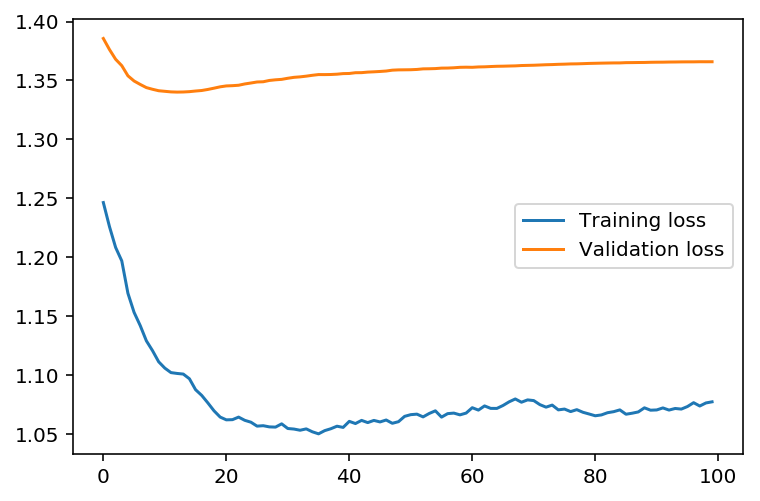

In [23]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
# plt.ylim(ymax=12.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

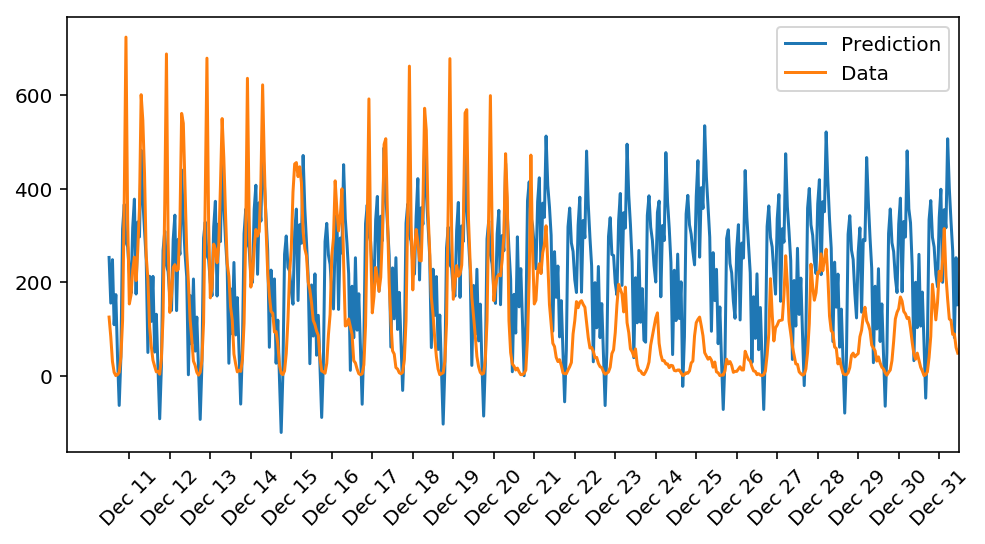

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.